In [600]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# plt.rcParams['figure.figsize'] = (12, 9)

# Importing Data

In [601]:
import json
from pandas.io.json import json_normalize

# raw_data = pd.read_json("json/data.json", orient="records") ; works but fewer columns

# Normalizing columns lets us get info from sub-arrays like 'share.link' and 'share.share_text'
with open('json/data.json') as data_file:    
    raw_data = json_normalize(json.load(data_file))

raw_data.columns

Index(['audio_files', 'call_duration', 'content', 'files', 'gifs', 'missed',
       'payment_info.amount', 'payment_info.completedTime',
       'payment_info.creationTime', 'payment_info.currency',
       'payment_info.receiverName', 'payment_info.senderName', 'photos',
       'plan.timestamp', 'plan.title', 'reactions', 'sender_name',
       'share.link', 'share.share_text', 'sticker.uri', 'timestamp_ms', 'type',
       'videos'],
      dtype='object')

In [602]:
raw_data['type'].value_counts()

Generic    34649
Share        421
Call          31
Payment        3
Plan           1
Name: type, dtype: int64

In [603]:
def decode_emoji(emoji):
    # UTF8 emojis were incorrectly exported as Latin-1.
    return emoji.encode('latin1').decode('utf8')

def parse_reactions(r): 
    """ Parses and returns the reactions for a conversation between exactly two people.
    
    INPUT:  [{'reaction': 'ð\x9f\x91\x8e', 'actor': 'Name1'},
            {'reaction': 'ð\x9f\x98¢', 'actor': 'Name2'}]
            
    OUTPUT: "Name1", 😮, "Name2", 😍
    """
    
    if type(r) != list:
        return None, None, None, None
    
    elif len(r) == 1:
        return r[0]['actor'], decode_emoji(r[0]['reaction']), None, None
    
    else:
        return r[0]['actor'], decode_emoji(r[0]['reaction']), r[1]['actor'], decode_emoji(r[1]['reaction'])

In [604]:
# parse reaction data
raw_data['actor1'], raw_data['reaction1'], raw_data['actor2'], raw_data['reaction2'] = \
    zip(*raw_data['reactions'].map(parse_reactions))

# raw_data.head(3)

# Initial Impressions

In [605]:
# only look at 'generic' messages
data = raw_data[raw_data['type'] == 'Generic'].copy()

print("NOTE: Lost these many non-generic rows: {} or {}%". \
      format(len(raw_data) - len(data), round(100*(len(raw_data) - len(data))/len(raw_data), 3)))

# slice out columns of interest
data = data.loc[:, ['sender_name', 'timestamp_ms', 'content', 'actor1', 'reaction1', 'actor2', 'reaction2']]

data.head()

NOTE: Lost these many non-generic rows: 456 or 1.299%


,sender_name,timestamp_ms,content,actor1,reaction1,actor2,reaction2
0,Joyce Luong,1550344792535,There are some techniques I wanna try that I f...,Andrew Huang,😮,None,None
1,Joyce Luong,1550344764151,tbh I wanna have another go at fishy stickers,None,None,None,None
2,Joyce Luong,1550344755800,:3 no worries,None,None,None,None
3,Andrew Huang,1550344742269,but I don't have an excuse to get a new laptop...,None,None,None,None
4,Andrew Huang,1550344724609,I can't wait to use those,Joyce Luong,😍,None,None


## Number of Messages Sent Per Person

In [606]:
data['sender_name'].value_counts()

Joyce Luong     19042
Andrew Huang    15607
Name: sender_name, dtype: int64

In [607]:
data['timestamp_ms'] = pd.to_datetime(data['timestamp_ms'], unit='ms') \
                 .dt.tz_localize('UTC') \
                 .dt.tz_convert('America/Los_Angeles')
                 
data['timestamp'] = data['timestamp_ms'].dt.strftime('%a, %b %d, %Y @ %r')
# data.head()

In [608]:
data['month'] = data['timestamp_ms'].dt.month
data['hour'] = data['timestamp_ms'].dt.hour
data['year_month'] = data['timestamp_ms'].dt.strftime('%Y-%m')
# data.head()

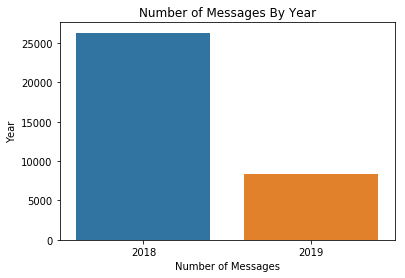

In [609]:
ax = sns.countplot(data['timestamp_ms'].dt.year)
ax.set_ylabel("Year")
ax.set_xlabel("Number of Messages")
ax.set_title("Number of Messages By Year");

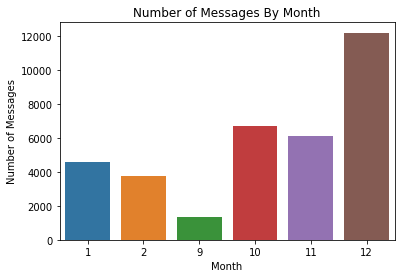

In [610]:
ax = sns.countplot(data['timestamp_ms'].dt.month)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Messages")
ax.set_title("Number of Messages By Month");

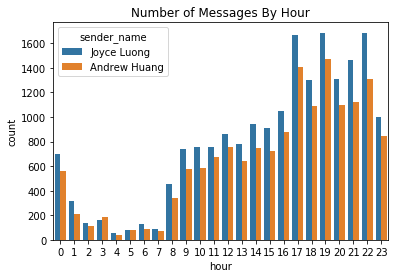

In [611]:

data['hour'] = data['timestamp_ms'].dt.hour
ax = sns.countplot(x='hour',hue='sender_name',data=data)
ax.set_title("Number of Messages By Hour");

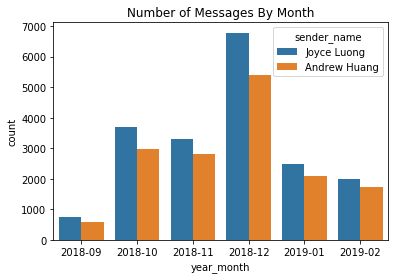

In [612]:
year_month = sorted(data['year_month'].unique()) # order to display the x-axis
ax = sns.countplot(x='year_month', hue='sender_name', data=data, order=year_month)
ax.set_title("Number of Messages By Month");

In [613]:
count_chars = lambda row: sum([len(message) for message in row])

reduced = data.loc[:, ['month', 'sender_name', 'content']]
char_len = reduced.groupby([reduced['month'], reduced['sender_name']]).agg(count_chars)

char_len.reset_index(inplace=True)

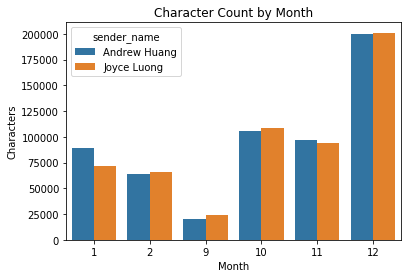

In [614]:
ax = sns.barplot(x='month', y='content', hue='sender_name', data=char_len)
ax.set_title("Character Count by Month");
ax.set_ylabel("Characters")
ax.set_xlabel("Month");

In [615]:
data.head()

,sender_name,timestamp_ms,content,actor1,reaction1,actor2,reaction2,timestamp,month,hour,year_month
0,Joyce Luong,2019-02-16 11:19:52.535000-08:00,There are some techniques I wanna try that I f...,Andrew Huang,😮,None,None,"Sat, Feb 16, 2019 @ 11:19:52 AM",2,11,2019-02
1,Joyce Luong,2019-02-16 11:19:24.151000-08:00,tbh I wanna have another go at fishy stickers,None,None,None,None,"Sat, Feb 16, 2019 @ 11:19:24 AM",2,11,2019-02
2,Joyce Luong,2019-02-16 11:19:15.800000-08:00,:3 no worries,None,None,None,None,"Sat, Feb 16, 2019 @ 11:19:15 AM",2,11,2019-02
3,Andrew Huang,2019-02-16 11:19:02.269000-08:00,but I don't have an excuse to get a new laptop...,None,None,None,None,"Sat, Feb 16, 2019 @ 11:19:02 AM",2,11,2019-02
4,Andrew Huang,2019-02-16 11:18:44.609000-08:00,I can't wait to use those,Joyce Luong,😍,None,None,"Sat, Feb 16, 2019 @ 11:18:44 AM",2,11,2019-02


In [616]:
data.to_json('correctoutput.json')